### LightFM Model for EBNeRD Dataset

Source: https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/lightfm_deep_dive.ipynb

### Shell

In [1]:
!pip install lightfm
!pip install git+https://github.com/microsoft/recommenders.git

  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-akqqqhmz
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-akqqqhmz
  Resolved https://github.com/microsoft/recommenders.git to commit 0aaa80b4ec029a20c99abb6fcf3b7efe42e57eb8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import libraries

In [2]:
import os
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k
from lightfm.evaluation import auc_score

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
LightFM version: 1.17


### Defining variables

In [3]:
# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 500
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 17

### Constant for how often we check and save AUC

In [4]:
EPOCH_RATIO_FOR_AUC = 100

### Output configuration readme file

In [6]:
# Generate README content
readme_content = f"""# LightFM Model Configuration

This README file contains the configuration parameters for training a LightFM model.

## Configuration Parameters

- Default number of recommendations (K): {K}
- Percentage of data used for testing: {TEST_PERCENTAGE}
- Model learning rate: {LEARNING_RATE}
- Number of latent factors: {NO_COMPONENTS}
- Number of epochs to fit model: {NO_EPOCHS}
- Number of threads to fit model: {NO_THREADS}
- Regularisation for item features (ITEM_ALPHA): {ITEM_ALPHA}
- Regularisation for user features (USER_ALPHA): {USER_ALPHA}
- Seed for pseudonumber generations: {SEED}
"""

# Write README content to file
with open("README.md", "w") as readme_file:
    readme_file.write(readme_content)

print("README.md file has been generated successfully.")

README.md file has been generated successfully.


### Retrieving data

Note that only one of the following options needs to be run. You can either use MovieLens data, EBNeRD data (given that you have access to drive), or a number of rows from EBNeRD data. All subsequent operations are the same for all 3 options.

#### Retrieve data - EBNeRD

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#data = pd.read_csv("/content/drive/MyDrive/combined_data_small.csv")
data = pd.read_csv("/content/drive/MyDrive/SW6/Colab notebooks/LightFM/combined_data_small.csv")
# quick look at the data
data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
293070,1664862,9761273,1,Kendt
3298577,542550,9757869,1,Erhverv
4892717,1719366,9788108,0,Erhverv
2070607,1012106,9766146,1,Samfund
1487204,1089003,9769306,1,Kriminalitet


#### Retrieve Data - EBNeRD (fixed row num)

### Prepare data

In [8]:
dataset = Dataset()

In [9]:
dataset.fit(users=data['userID'],
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 18827, num_topics: 13018.


In [10]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

In [11]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

In [12]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (18827, 13018)
Shape of test interactions: (18827, 13018)


### Instantiate the LightFM model

In [ ]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS,
                 learning_rate=LEARNING_RATE,
                 random_state=np.random.RandomState(SEED))

### OR Reload model

In [13]:
model1 = joblib.load("/content/drive/MyDrive/SW6/Colab notebooks/LightFM/Sprint 5 Research/Exported Data/lightfm_model_combined_data_small.joblib")

### Model fit and evaluation (AUC)



It takes 3 minutes and 20 seconds to run train with AUC.
It takes 6 minutes and 40 seconds to run 10 epochs with 2 AUC tests.
This means that other than AUC score calculation, computational time is negligible.

#### Initial train

In [14]:
test_interactions_excl_train = test_interactions - train_interactions.multiply(test_interactions)

# Store AUC scores for each epoch
train_auc_scores_per_epoch = []
test_auc_scores_per_epoch = []

In [ ]:
# Initial fit
model1.fit(interactions=train_interactions,
          epochs=1);

train_auc_score_epoch = auc_score(model1, train_interactions,
                                num_threads=NO_THREADS)

test_auc_score_epoch = auc_score(model1, test_interactions=test_interactions_excl_train,
                                num_threads=NO_THREADS)

# Append AUC score to list
train_auc_scores_per_epoch.append(np.mean(train_auc_score_epoch))
test_auc_scores_per_epoch.append(np.mean(test_auc_score_epoch))

# Print AUC after first epoch
print("Epoch: 0 - Train AUC: {:.6f} - Test AUC: {:.6f}".format(np.mean(train_auc_score_epoch), np.mean(test_auc_score_epoch)))


Epoch: 0 - Train AUC: 0.525630 - Test AUC: 0.517648


You can run the code below this text multiple times, because it is partial fit. :D

If your NO_EPOCS constant is 500 and you want to extend your training to 1000 epochs, just execute the cell twice, your progress will not be lost or overwritten! :)

Remember to save your data and model between big runs. If Google Colab crashes, you can continue from there. :3

In [15]:
for epoch in range(1, NO_EPOCHS + 1):  # Start from epoch 1 since we already computed for epoch 0
    # Fit model for current epoch
    model1.fit_partial(interactions=train_interactions, epochs=1)

    # Calculate AUC score for current epoch
    if epoch % EPOCH_RATIO_FOR_AUC == 0:
        train_auc_score_epoch = auc_score(model1, train_interactions,
                                          num_threads=NO_THREADS)

        test_auc_score_epoch = auc_score(model1, test_interactions=test_interactions_excl_train,
                                         num_threads=NO_THREADS)

        # Append AUC score to list
        train_auc_scores_per_epoch.append(np.mean(train_auc_score_epoch))
        test_auc_scores_per_epoch.append(np.mean(test_auc_score_epoch))

        print("Epoch: {} - Train AUC: {:.6f} - Test AUC: {:.6f}".format(epoch, np.mean(train_auc_score_epoch), np.mean(test_auc_score_epoch)))

Epoch: 100 - Train AUC: 0.903996 - Test AUC: 0.886337
Epoch: 200 - Train AUC: 0.904261 - Test AUC: 0.886683
Epoch: 300 - Train AUC: 0.904507 - Test AUC: 0.887015
Epoch: 400 - Train AUC: 0.904733 - Test AUC: 0.887307
Epoch: 500 - Train AUC: 0.904944 - Test AUC: 0.887604


### Save data as CSV
Headers are Epoch number, train AUC, test AUC.

In [16]:
import pandas as pd

# Create a DataFrame from the tabular data
data = {
    "Epoch": range(0, NO_EPOCHS, EPOCH_RATIO_FOR_AUC),
    "Train AUC": train_auc_scores_per_epoch,
    "Test AUC": test_auc_scores_per_epoch
}
print (data)
df = pd.DataFrame(data)

# Save DataFrame to CSV file
df.to_csv("auc_scores_per_epoch.csv", index=False)

print("CSV file has been saved successfully.")


{'Epoch': range(0, 500, 100), 'Train AUC': [0.90399647, 0.9042607, 0.9045073, 0.9047331, 0.9049443], 'Test AUC': [0.8863365, 0.8866832, 0.8870154, 0.88730705, 0.88760424]}
CSV file has been saved successfully.


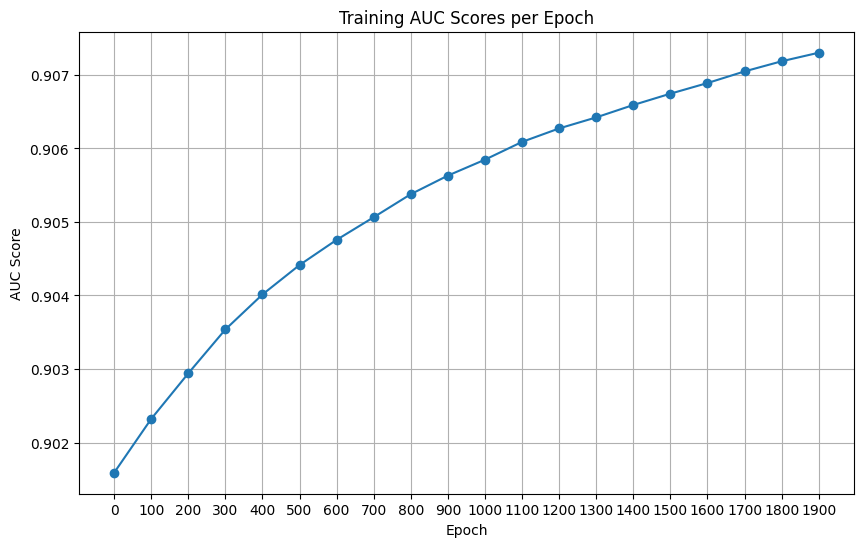

In [ ]:
# Plot AUC scores per epoch if the list is not empty
if train_auc_scores_per_epoch:
    x_values = [i * EPOCH_RATIO_FOR_AUC for i in range(len(train_auc_scores_per_epoch))]
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, train_auc_scores_per_epoch, marker='o', linestyle='-')
    plt.title('Training AUC Scores per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.grid(True)
    plt.xticks(x_values)
    plt.show()
else:
    print("No AUC scores to plot.")


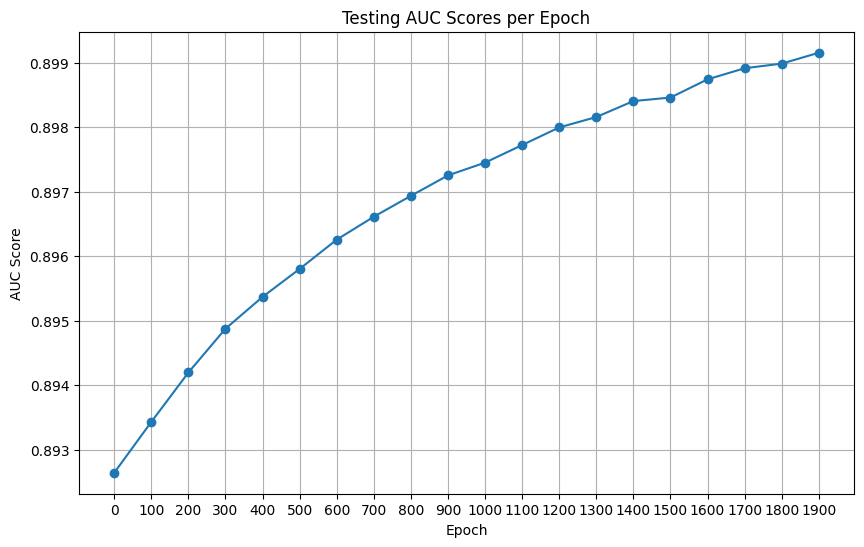

In [ ]:
# Plot AUC scores per epoch if the list is not empty
if test_auc_scores_per_epoch:
    x_values = [i * EPOCH_RATIO_FOR_AUC for i in range(len(test_auc_scores_per_epoch))]
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, test_auc_scores_per_epoch, marker='o', linestyle='-')
    plt.title('Testing AUC Scores per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.grid(True)
    plt.xticks(x_values)
    plt.show()
else:
    print("No AUC scores to plot.")


### Export the model

In [17]:
import joblib
joblib.dump(model1, 'lightfm_model_combined_data_small.joblib')

['lightfm_model_combined_data_small.joblib']